In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.5,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_05_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:50 - loss: 0.0436 - STD: 1.0399e-04 - MAE: 0.1902

 11/632 [..............................] - ETA: 3s - loss: 0.0210 - STD: 2.1768e-04 - MAE: 0.1109   

 20/632 [..............................] - ETA: 3s - loss: 0.0168 - STD: 2.5257e-04 - MAE: 0.1013

 29/632 [>.............................] - ETA: 3s - loss: 0.0150 - STD: 2.8364e-04 - MAE: 0.0937

 38/632 [>.............................] - ETA: 3s - loss: 0.0138 - STD: 3.3902e-04 - MAE: 0.0906

 47/632 [=>............................] - ETA: 3s - loss: 0.0130 - STD: 3.9660e-04 - MAE: 0.0876

 56/632 [=>............................] - ETA: 3s - loss: 0.0124 - STD: 4.8107e-04 - MAE: 0.0860

 65/632 [==>...........................] - ETA: 3s - loss: 0.0121 - STD: 5.8986e-04 - MAE: 0.0849

 74/632 [==>...........................] - ETA: 3s - loss: 0.0119 - STD: 7.5349e-04 - MAE: 0.0842

 83/632 [==>...........................] - ETA: 3s - loss: 0.0116 - STD: 0.0010 - MAE: 0.0834    

 92/632 [===>..........................] - ETA: 3s - loss: 0.0114 - STD: 0.0014 - MAE: 0.0828

101/632 [===>..........................] - ETA: 3s - loss: 0.0112 - STD: 0.0021 - MAE: 0.0821

110/632 [====>.........................] - ETA: 3s - loss: 0.0110 - STD: 0.0032 - MAE: 0.0815

119/632 [====>.........................] - ETA: 2s - loss: 0.0108 - STD: 0.0049 - MAE: 0.0808

128/632 [=====>........................] - ETA: 2s - loss: 0.0106 - STD: 0.0070 - MAE: 0.0801

137/632 [=====>........................] - ETA: 2s - loss: 0.0105 - STD: 0.0090 - MAE: 0.0793

146/632 [=====>........................] - ETA: 2s - loss: 0.0103 - STD: 0.0109 - MAE: 0.0788

155/632 [======>.......................] - ETA: 2s - loss: 0.0102 - STD: 0.0127 - MAE: 0.0782

164/632 [======>.......................] - ETA: 2s - loss: 0.0100 - STD: 0.0144 - MAE: 0.0776

173/632 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 0.0159 - MAE: 0.0771

182/632 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 0.0174 - MAE: 0.0765

191/632 [========>.....................] - ETA: 2s - loss: 0.0096 - STD: 0.0187 - MAE: 0.0759

200/632 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0202 - MAE: 0.0752

209/632 [========>.....................] - ETA: 2s - loss: 0.0094 - STD: 0.0217 - MAE: 0.0746

218/632 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 0.0233 - MAE: 0.0739

227/632 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.0247 - MAE: 0.0733

236/632 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0261 - MAE: 0.0728

245/632 [==========>...................] - ETA: 2s - loss: 0.0089 - STD: 0.0273 - MAE: 0.0723

254/632 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0284 - MAE: 0.0718

263/632 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0295 - MAE: 0.0712

272/632 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0306 - MAE: 0.0708

281/632 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0316 - MAE: 0.0703

290/632 [============>.................] - ETA: 2s - loss: 0.0084 - STD: 0.0326 - MAE: 0.0698

299/632 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0335 - MAE: 0.0694

308/632 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0344 - MAE: 0.0692

317/632 [==============>...............] - ETA: 1s - loss: 0.0082 - STD: 0.0350 - MAE: 0.0688

326/632 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0358 - MAE: 0.0684

335/632 [==============>...............] - ETA: 1s - loss: 0.0080 - STD: 0.0366 - MAE: 0.0680

344/632 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0374 - MAE: 0.0677

353/632 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0382 - MAE: 0.0673

362/632 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0388 - MAE: 0.0670

371/632 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0395 - MAE: 0.0667

380/632 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0401 - MAE: 0.0663

389/632 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0408 - MAE: 0.0661

398/632 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0413 - MAE: 0.0658

407/632 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0419 - MAE: 0.0655

415/632 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0423 - MAE: 0.0653

423/632 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0429 - MAE: 0.0650

432/632 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0434 - MAE: 0.0647

441/632 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0440 - MAE: 0.0645

450/632 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0445 - MAE: 0.0642

459/632 [====================>.........] - ETA: 1s - loss: 0.0072 - STD: 0.0450 - MAE: 0.0640

468/632 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0454 - MAE: 0.0637

477/632 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0459 - MAE: 0.0635

486/632 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0463 - MAE: 0.0633

495/632 [======================>.......] - ETA: 0s - loss: 0.0071 - STD: 0.0467 - MAE: 0.0631

504/632 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0471 - MAE: 0.0629

513/632 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0475 - MAE: 0.0627

522/632 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0479 - MAE: 0.0625

531/632 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0482 - MAE: 0.0623

540/632 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0486 - MAE: 0.0621

549/632 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0490 - MAE: 0.0620

558/632 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0493 - MAE: 0.0618

567/632 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0497 - MAE: 0.0616

576/632 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0500 - MAE: 0.0615

585/632 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0503 - MAE: 0.0613

594/632 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0506 - MAE: 0.0611

600/632 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0509 - MAE: 0.0610

611/632 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0512 - MAE: 0.0608

620/632 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0515 - MAE: 0.0607

629/632 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0517 - MAE: 0.0606

632/632 [==============================] - 6s 8ms/step - loss: 0.0066 - STD: 0.0518 - MAE: 0.0606 - val_loss: 0.0044 - val_STD: 0.0499 - val_MAE: 0.0480


Epoch 2/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0477

  8/632 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509 

 17/632 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

 26/632 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

 35/632 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0506

 44/632 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0505

 53/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

 62/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509

 71/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0509

 80/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

 89/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

 98/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

107/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

116/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

125/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

134/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

143/632 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

152/632 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

161/632 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

171/632 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

180/632 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0506

189/632 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

198/632 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0507

207/632 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0507

216/632 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0507

225/632 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0507

234/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

243/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0506

252/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0505

261/632 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

270/632 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0505

278/632 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

287/632 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

296/632 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0505

305/632 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

314/632 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

323/632 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

332/632 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

341/632 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

349/632 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

358/632 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0502

367/632 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0502

376/632 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0501

385/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

394/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

403/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

412/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

421/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

430/632 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

439/632 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

447/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

456/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

465/632 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

473/632 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

482/632 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

491/632 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

500/632 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

509/632 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

518/632 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

527/632 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

536/632 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

545/632 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

554/632 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

563/632 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

572/632 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

581/632 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

590/632 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

599/632 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

608/632 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

617/632 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

626/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

632/632 [==============================] - 4s 6ms/step - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495 - val_loss: 0.0038 - val_STD: 0.0570 - val_MAE: 0.0451


Epoch 3/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0481

  9/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478 

 18/632 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

 27/632 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

 36/632 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0484

 45/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0486

 54/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0484

 63/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0484

 72/632 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0484

 81/632 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0483

 90/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483

 99/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0483

108/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

117/632 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

126/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0483

135/632 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0482

144/632 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

153/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

162/632 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

171/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

180/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

189/632 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

198/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

207/632 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

216/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

225/632 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

234/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

243/632 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

252/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

261/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

270/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477

279/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

288/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

297/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

306/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

315/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

324/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

333/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

342/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

351/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

360/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

369/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

378/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

387/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

396/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

405/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

414/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

423/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

432/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

441/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

450/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

459/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

468/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

476/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

485/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

495/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

504/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

513/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

522/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

531/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

540/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

549/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

558/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

567/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

576/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

585/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

594/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

603/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

611/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

619/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

628/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

632/632 [==============================] - 4s 6ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473 - val_loss: 0.0039 - val_STD: 0.0543 - val_MAE: 0.0447


Epoch 4/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0035 - STD: 0.0689 - MAE: 0.0437

  8/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0455 

 17/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0455

 26/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

 35/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

 44/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0463

 53/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

 62/632 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

 71/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

 80/632 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

 89/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467

 98/632 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

107/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

116/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

125/632 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

134/632 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

143/632 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

152/632 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

161/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

170/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

179/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

188/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464

197/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

206/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

215/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

224/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

233/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

242/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

251/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

260/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

268/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

277/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

285/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

293/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

302/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

311/632 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

320/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

329/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

338/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

347/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

356/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

365/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

374/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

383/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

392/632 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

401/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

410/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

419/632 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

428/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

437/632 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

446/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

455/632 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

464/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

473/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

482/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

491/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

500/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

509/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

518/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

527/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

536/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

545/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

554/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

563/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

571/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

580/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

589/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

598/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

607/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

616/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

625/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

632/632 [==============================] - 4s 6ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457 - val_loss: 0.0038 - val_STD: 0.0637 - val_MAE: 0.0454


Epoch 5/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0036 - STD: 0.0835 - MAE: 0.0450

  9/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453 

 18/632 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

 27/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 36/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

 45/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

 54/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

 63/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

 72/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

 81/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

 90/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

 99/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

108/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

117/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

126/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

135/632 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

144/632 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

153/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

162/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

171/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

180/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

188/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

196/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

205/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

214/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

223/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

232/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

241/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

250/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

259/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

268/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

277/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

286/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

295/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

304/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

313/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

322/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

331/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

339/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

348/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

357/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

366/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

375/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

384/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

392/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

401/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

410/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

419/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

428/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

437/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

446/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

455/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

464/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

473/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

482/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

491/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

500/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

508/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

517/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

526/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

535/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

544/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

553/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

562/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

571/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

580/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

589/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

598/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

607/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

616/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

625/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

632/632 [==============================] - 4s 6ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451 - val_loss: 0.0038 - val_STD: 0.0646 - val_MAE: 0.0466


Epoch 6/10000


  1/632 [..............................] - ETA: 21s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0449

  7/632 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445 

 15/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0449

 23/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

 32/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

 40/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

 49/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

 58/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

 67/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

 76/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

 85/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

 94/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

103/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

112/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

121/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

130/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

139/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

148/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

157/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

166/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

175/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

184/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

193/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

202/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

211/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

220/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

229/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

238/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

247/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

256/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

265/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

274/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

283/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

292/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

301/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

309/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

317/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

326/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

335/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

344/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

353/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

362/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

371/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

380/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

389/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

398/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

407/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

416/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

425/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

434/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

443/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

452/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

461/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

470/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

479/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

488/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

497/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

506/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

515/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

524/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

533/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

541/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

550/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

559/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

568/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

577/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

586/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

595/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

604/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

613/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

622/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

631/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443 - val_loss: 0.0040 - val_STD: 0.0668 - val_MAE: 0.0475


Epoch 7/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0038 - STD: 0.0847 - MAE: 0.0475

  7/632 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448 

 16/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0449

 25/632 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 34/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

 43/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

 52/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

 60/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

 69/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

 78/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

 87/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

 96/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

105/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

114/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

123/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

132/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

141/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

150/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

159/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

168/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

177/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

186/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

195/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

204/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

213/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

222/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

231/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

249/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

258/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

267/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

276/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

286/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

294/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

303/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

312/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

321/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

330/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

339/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

348/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

357/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

366/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

375/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

383/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

392/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

401/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

409/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

418/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

427/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

435/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

443/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

451/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

459/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

468/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

477/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

486/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

495/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

504/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

513/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

522/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

531/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

539/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

548/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

557/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

566/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

574/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

583/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

592/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

601/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

610/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

619/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

628/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437 - val_loss: 0.0035 - val_STD: 0.0637 - val_MAE: 0.0435


Epoch 8/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0430

  7/632 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0823 - MAE: 0.0430 

 16/632 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0426

 25/632 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

 34/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0430

 43/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0431

 52/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

 61/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

 70/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

 79/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

 88/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

 96/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

105/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

114/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

123/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

132/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

141/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

150/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

159/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

168/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

177/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

186/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

195/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

204/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

213/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

222/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

231/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

240/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

249/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

258/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

267/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

276/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

285/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

294/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

303/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

312/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

321/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

330/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

339/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

348/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

357/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

366/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

375/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

384/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

393/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

402/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

411/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

420/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

429/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

438/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

447/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

456/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

465/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

473/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

481/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

490/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

499/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

508/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

517/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

526/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

535/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

544/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

553/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

562/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

571/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

580/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

589/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

598/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

607/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

616/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

625/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

632/632 [==============================] - 4s 6ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431 - val_loss: 0.0036 - val_STD: 0.0630 - val_MAE: 0.0431


Epoch 9/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

  9/632 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0423 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

 27/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0424

 36/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0426

 45/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0425

 54/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

 63/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0428

 72/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0427

 81/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

 90/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0427

 99/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

107/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

116/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0426

125/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0426

134/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

142/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

151/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

160/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

169/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

178/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

187/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

196/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

205/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

214/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

223/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

232/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0429

241/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

250/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

259/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

268/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

277/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0429

286/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

295/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

304/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

313/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

322/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

331/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

340/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

349/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

358/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0429

367/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

376/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0429

385/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

394/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

403/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

412/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

421/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

430/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

439/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

448/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

457/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

466/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

475/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

484/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

493/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

502/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

511/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

520/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

529/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

538/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

547/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

556/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

565/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

574/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

583/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

592/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

601/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

610/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

619/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

628/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

632/632 [==============================] - 4s 6ms/step - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427 - val_loss: 0.0036 - val_STD: 0.0595 - val_MAE: 0.0431


Epoch 10/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0429

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0807 - MAE: 0.0430 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

 28/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

 37/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0430

 46/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0429

 55/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0429

 64/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

 73/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

 82/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

 91/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

100/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0431

109/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

118/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0431

127/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

136/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0430

145/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

154/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0430

163/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

171/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0429

180/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0429

189/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0429

198/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0428

207/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0428

215/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

224/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

233/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

242/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

251/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

260/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

269/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

278/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

287/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

296/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

305/632 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

314/632 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

323/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

332/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

341/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

350/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

359/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

368/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

377/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

386/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

395/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

404/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

413/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

422/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

431/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

440/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

449/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0424

458/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0424

467/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

476/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

485/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

494/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

503/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

512/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

521/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

529/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0424

538/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

547/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

556/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

565/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

574/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

583/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

591/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

600/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

609/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

618/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

627/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

632/632 [==============================] - 4s 6ms/step - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423 - val_loss: 0.0038 - val_STD: 0.0582 - val_MAE: 0.0440


Epoch 11/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0036 - STD: 0.0723 - MAE: 0.0428

 10/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0429 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

 28/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0431

 37/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

 46/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0427

 55/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0426

 64/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0425

 73/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

 82/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

 91/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0426

100/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0425

109/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0426

118/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

127/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0425

136/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0425

145/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0424

154/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0424

163/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0424

172/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0423

181/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0423

190/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0422

200/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0422

209/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0422

218/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0422

227/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0421

236/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0421

245/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

254/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

263/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

272/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

280/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

289/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

298/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

307/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

316/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

325/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

334/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

343/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

352/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

361/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

370/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

379/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

388/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

397/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

406/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

415/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

424/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

433/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

441/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

449/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

457/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

466/632 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

475/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

484/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

493/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

502/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

511/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

520/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

529/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

538/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

547/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

555/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

563/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

572/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

581/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

590/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

598/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

607/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

616/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

624/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418 - val_loss: 0.0034 - val_STD: 0.0652 - val_MAE: 0.0427


Epoch 12/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0420

  9/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0406 

 18/632 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0407

 26/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0810 - MAE: 0.0407

 35/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0806 - MAE: 0.0408

 44/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0808 - MAE: 0.0409

 53/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0407

 62/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0407

 71/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

 80/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

 89/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0416

 98/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0416

106/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0416

114/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0415

123/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0415

132/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0416

141/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0416

150/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0416

158/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0416

167/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0415

176/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0415

185/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0416

194/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0416

203/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0415

212/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

221/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

230/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

239/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

248/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

257/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

266/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

275/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

283/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

292/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

301/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0414

310/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

319/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0414

328/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0414

337/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

346/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

355/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

364/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

373/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

382/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

391/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0415

400/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

409/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

418/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

427/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

436/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

445/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

454/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

463/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

472/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

481/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

490/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

499/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

508/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

517/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

526/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

535/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

544/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

553/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

562/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

571/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

580/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0414

589/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

598/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

607/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

615/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

624/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414 - val_loss: 0.0037 - val_STD: 0.0554 - val_MAE: 0.0431


Epoch 13/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0715 - MAE: 0.0415

  9/632 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0796 - MAE: 0.0410 

 18/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0414

 27/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0417

 36/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0416

 45/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0415

 54/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0413

 63/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

 72/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

 81/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0412

 90/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

 99/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

108/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

117/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0411

126/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

136/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

145/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

154/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

163/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

172/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

180/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

189/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

198/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

207/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

216/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

225/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

234/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

243/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

252/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

261/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

270/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

279/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

288/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

297/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

306/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

315/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

324/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

332/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

341/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

350/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

359/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

368/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

377/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

386/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

395/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

404/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

413/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

422/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

431/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

439/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

447/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

455/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

463/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

472/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

480/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

489/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

498/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

504/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

512/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

520/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

529/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

538/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

547/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

556/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

565/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

574/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

583/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

592/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

601/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

610/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

619/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

628/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411 - val_loss: 0.0040 - val_STD: 0.0721 - val_MAE: 0.0465


Epoch 14/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0036 - STD: 0.0868 - MAE: 0.0441

  9/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0412 

 18/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0416

 27/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0804 - MAE: 0.0412

 36/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0408

 45/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

 54/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0407

 62/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0407

 71/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

 79/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

 88/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0407

 97/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0406

106/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0406

115/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

124/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0407

133/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0407

142/632 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0821 - MAE: 0.0407

151/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0821 - MAE: 0.0407

160/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0822 - MAE: 0.0407

169/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0821 - MAE: 0.0407

178/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0821 - MAE: 0.0407

187/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0407

195/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0407

203/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0407

212/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0407

220/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0407

229/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0407

238/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0406

247/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0406

256/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0406

265/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0406

274/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0407

283/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0407

291/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0407

299/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

307/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

316/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

324/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

333/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

342/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

351/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

360/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0407

369/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0407

378/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0407

386/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

395/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

403/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

411/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

420/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

428/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

436/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

445/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

453/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

461/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

470/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

479/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

488/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

497/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

506/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

514/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

523/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

532/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

541/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

550/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

559/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

568/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

577/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

585/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

594/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

603/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

612/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

621/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

630/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406 - val_loss: 0.0035 - val_STD: 0.0645 - val_MAE: 0.0425


Epoch 15/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

  8/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0831 - MAE: 0.0405 

 17/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0405

 26/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

 34/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

 42/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

 51/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0403

 60/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0403

 69/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

 78/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

 86/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0401

 94/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0401

103/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

112/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0402

121/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

130/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

139/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

148/632 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

157/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

166/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

175/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

184/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

193/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

202/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

211/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

220/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

229/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

238/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

247/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

256/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

265/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

274/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

283/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

292/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

301/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

310/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

319/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

328/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

337/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

346/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

355/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

364/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

373/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

382/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

391/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

400/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

409/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

418/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

427/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

436/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

445/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

454/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

463/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

470/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

479/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

488/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

497/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

506/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

515/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

524/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

533/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

542/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

551/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

560/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

569/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

578/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

587/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

596/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

605/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

614/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

622/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

631/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403 - val_loss: 0.0037 - val_STD: 0.0653 - val_MAE: 0.0438


Epoch 16/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0405

  9/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0821 - MAE: 0.0398 

 18/632 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0400

 27/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0398

 36/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

 45/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

 54/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0398

 63/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0400

 72/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

 81/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

 90/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

 99/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0402

108/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0402

117/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

126/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0401

135/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

144/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

153/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

162/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

171/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0401

180/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0401

189/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0401

198/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0401

204/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0401

212/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0401

221/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0401

230/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0401

239/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

248/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

257/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

266/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

275/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0400

284/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

293/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0400

302/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

311/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

320/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0400

329/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0400

338/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

346/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

355/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

364/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

373/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

382/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

391/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

400/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

409/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

418/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

427/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

436/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

445/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

454/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

463/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

472/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

481/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

490/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

499/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

508/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

517/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

526/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

535/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

544/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

553/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

562/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

571/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

580/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

589/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

598/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

607/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

616/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

624/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

632/632 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400 - val_loss: 0.0034 - val_STD: 0.0674 - val_MAE: 0.0423


Epoch 17/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0829 - MAE: 0.0402

  7/632 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0808 - MAE: 0.0401 

 15/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0820 - MAE: 0.0393

 24/632 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0395

 33/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0823 - MAE: 0.0394

 42/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0394

 51/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0396

 60/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0832 - MAE: 0.0395

 69/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0833 - MAE: 0.0396

 77/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0833 - MAE: 0.0396

 86/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0396

 95/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0397

104/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0397

112/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0396

121/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0832 - MAE: 0.0397

130/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0833 - MAE: 0.0397

139/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0832 - MAE: 0.0397

148/632 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0397

157/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0398

166/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0398

174/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0398

181/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0398

190/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0398

199/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0398

208/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0397

217/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0397

226/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

235/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

244/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0398

253/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

262/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

271/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

280/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

289/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

298/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

307/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

316/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

325/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

333/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0397

341/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

350/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

359/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

368/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

377/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

386/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

395/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

404/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

413/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

422/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

431/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

440/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

449/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

458/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

467/632 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

476/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

485/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

494/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

503/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

512/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

521/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

530/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

537/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

545/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

554/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

563/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

572/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

580/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

589/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

598/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

606/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

614/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

622/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

631/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397 - val_loss: 0.0035 - val_STD: 0.0679 - val_MAE: 0.0423


Epoch 18/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0031 - STD: 0.0871 - MAE: 0.0396

  9/632 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0831 - MAE: 0.0386 

 18/632 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0832 - MAE: 0.0386

 27/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0389

 36/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0391

 44/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0396

 53/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0398

 62/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

 71/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

 80/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

 89/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0398

 98/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0397

106/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0397

115/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0396

124/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

132/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

141/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

150/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

159/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0395

168/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

177/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

186/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

195/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

204/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

213/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

222/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

231/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

240/632 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

249/632 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

258/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

267/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

276/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

285/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

294/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

303/632 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

312/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

321/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

330/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

339/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

348/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

357/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

366/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

375/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

384/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

393/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

402/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

411/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

420/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

429/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

437/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

446/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

455/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

464/632 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

473/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

482/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

491/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

500/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

509/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

518/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

527/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

536/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

545/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

554/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

563/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

572/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

581/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

590/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

600/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0395

609/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

618/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

627/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395 - val_loss: 0.0036 - val_STD: 0.0623 - val_MAE: 0.0429


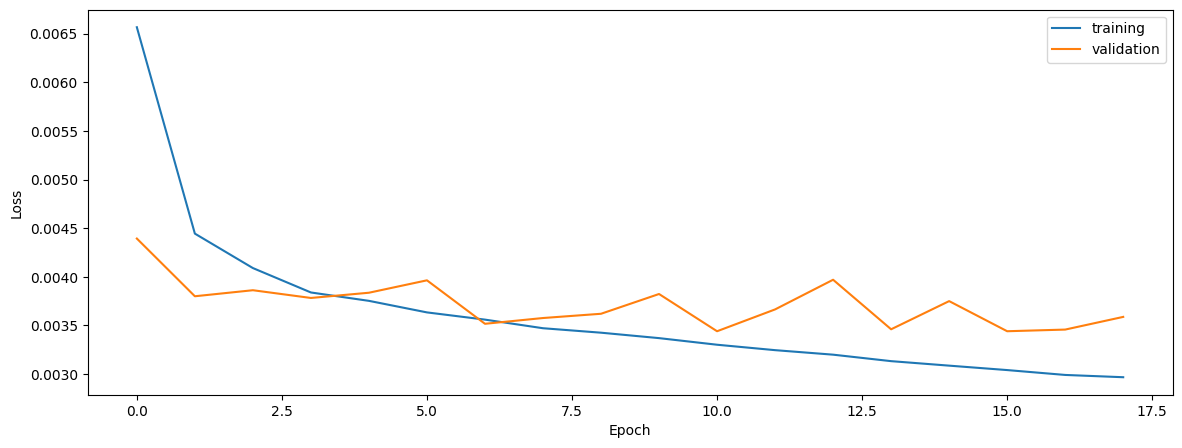

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8255909672356261
0.79694398101043
0.8076719309224917


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8255909672356261
0.79694398101043
0.8076719309224917


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8295355720322546
0.7977977542134346
0.8130170883222926


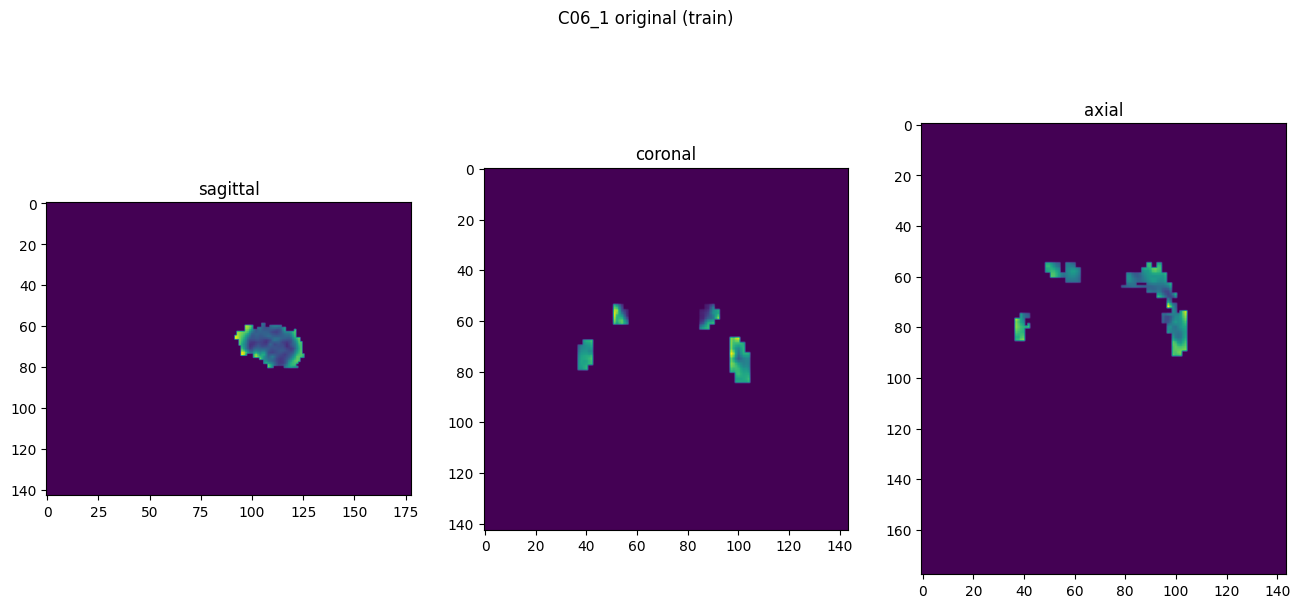

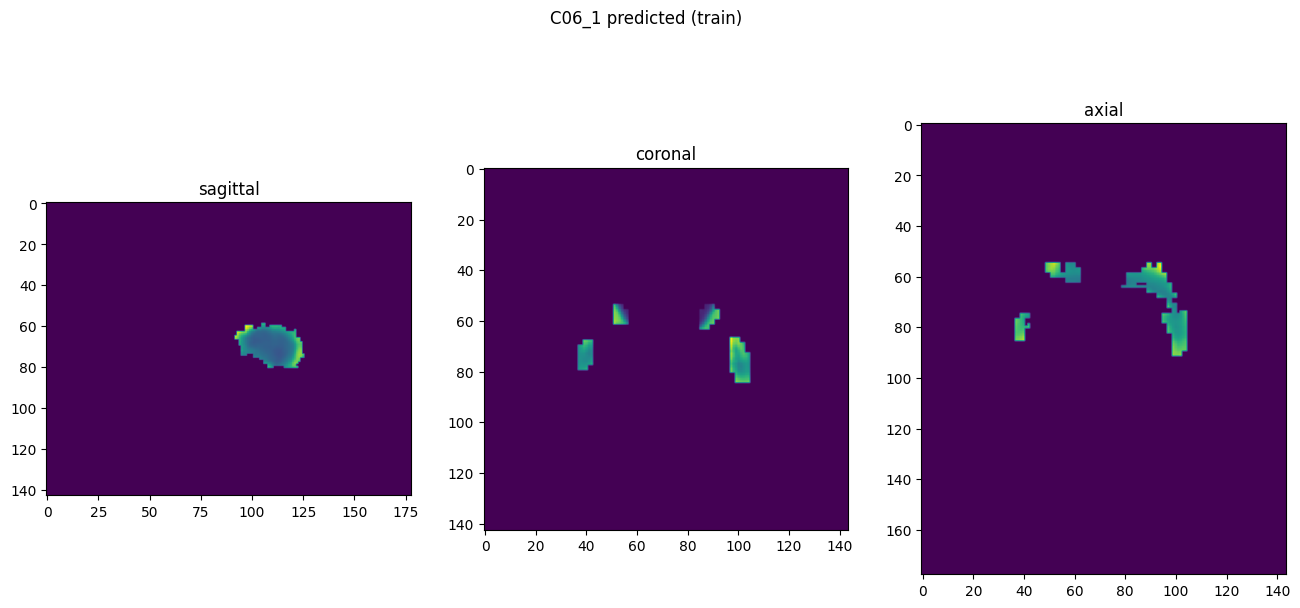

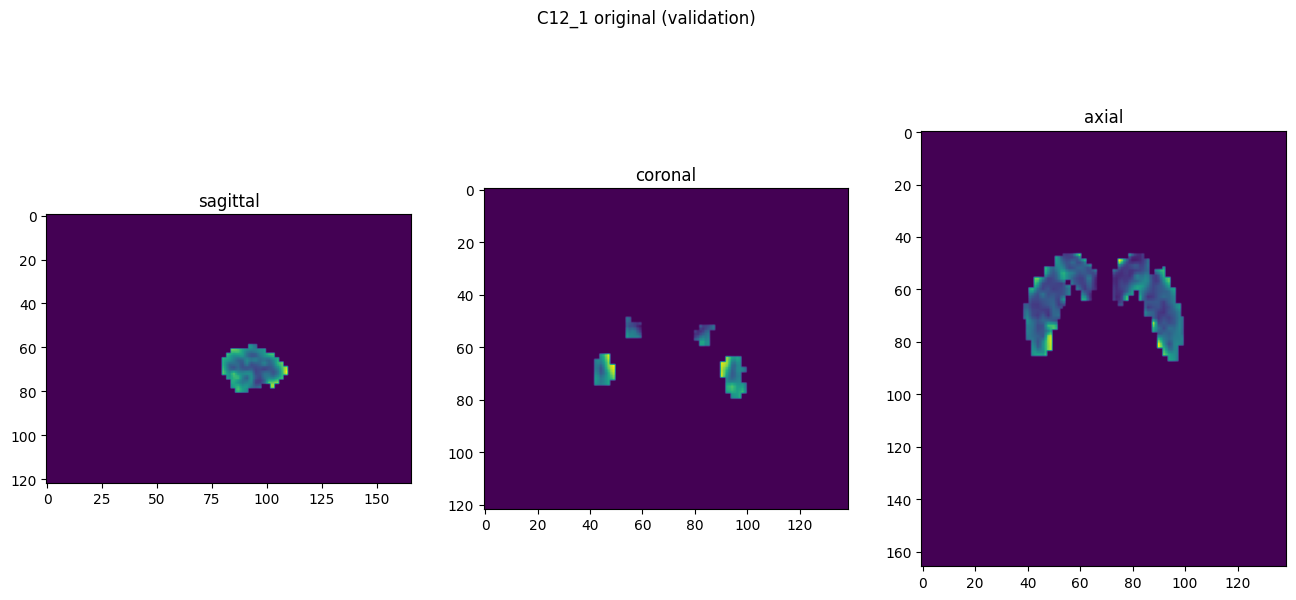

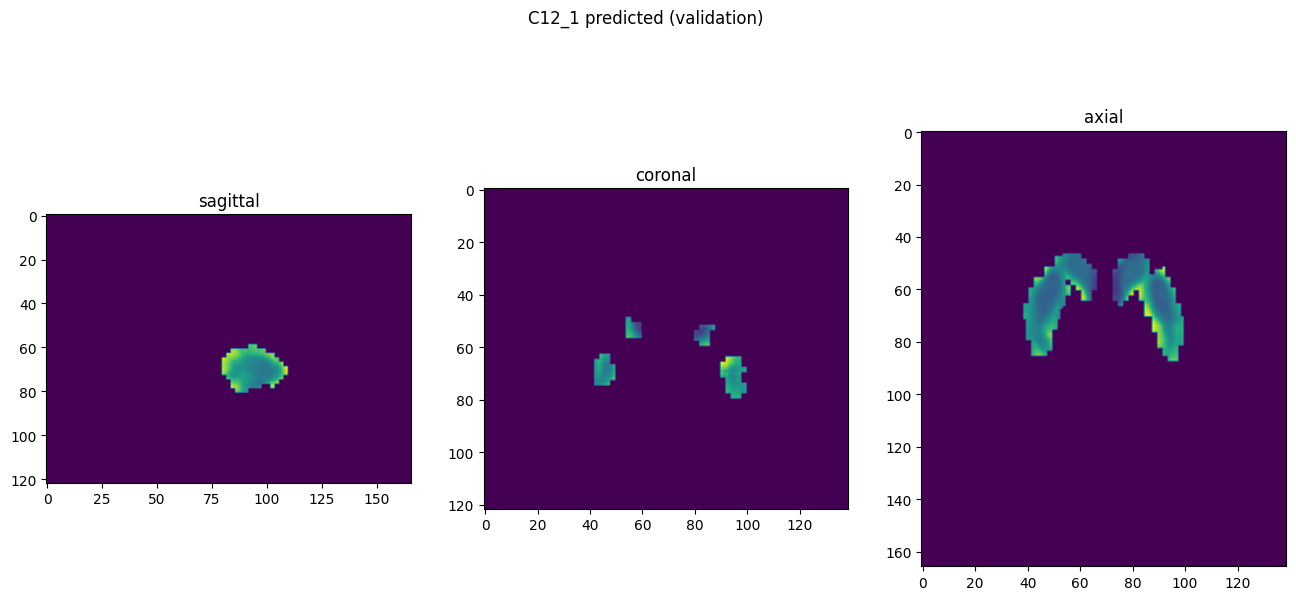

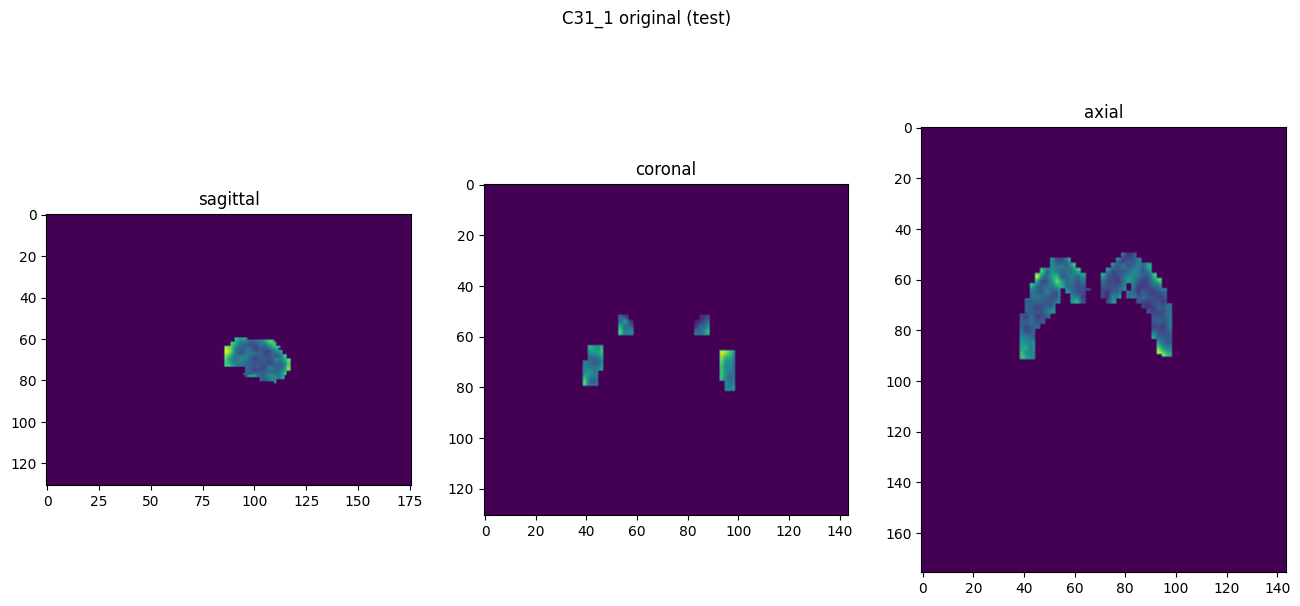

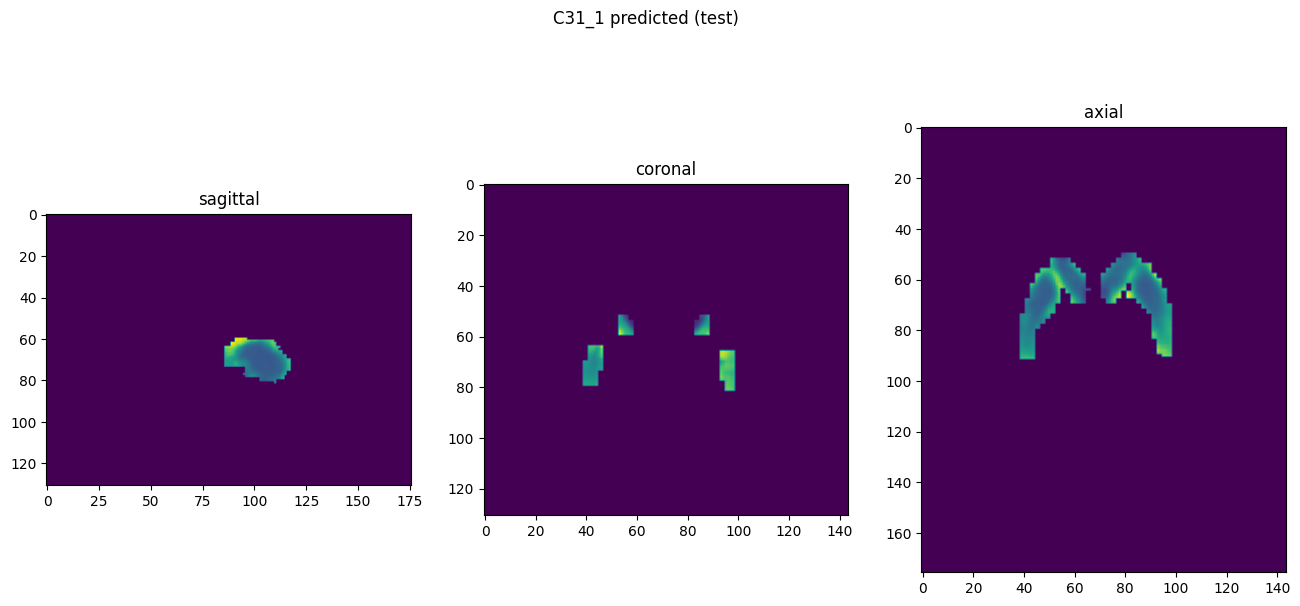

In [10]:
showResults(model, gen, threshold=None, background=False)